<a href="https://colab.research.google.com/github/claudio1975/Climate_Risk_Modelling_with_LLMs/blob/main/Flood_prediction_deaths_direct_work_v_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.1 MB/s eta 0:00:00


In [2]:
# utils packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import radians, sin, cos, sqrt, atan2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint

# models and utils packages for prediction
from sklearn.linear_model import TweedieRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# to evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import shap

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Upload data set

In [3]:
df=pd.read_csv('./flood_dataset_fe3.csv',index_col=0)

### Handling Date Time format

In [4]:
# Trasform BEGIN_DATE_TIME and END_DATE_TIME in datetime format
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format="%d-%b-%y %H:%M:%S")
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format="%d-%b-%y %H:%M:%S")

In [5]:
# Cast datetime variable in datetime format.
df.index = pd.to_datetime(df.BEGIN_DATE_TIME)
df.index.names = ['Date']
# Sort DataFrame by date column in descending order
df.sort_values(by='Date', ascending = True, inplace = True)
# Sanity check: data span.
df.index.min(), df.index.max()

(Timestamp('2006-10-02 14:00:00'), Timestamp('2022-12-31 23:00:00'))

### Have a brief look of the data set

In [6]:
df.shape

(38398, 52)

In [7]:
df.columns

Index(['EVENT_ID', 'BEGIN_DATE_TIME', 'END_DATE_TIME', 'STATE', 'STATE_FIPS',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON',
       'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'embed_episod_gpt0', 'embed_episod_gpt1',
       'embed_episod_gpt2', 'embed_episod_gpt3', 'embed_episod_gpt4',
       'embed_episod_gpt5', 'embed_episod_gpt6', 'embed_episod_gpt7',
       'embed_episod_gpt8', 'embed_episod_gpt9', 'embed_event_gpt0',
       'embed_event_gpt1', 'embed_event_gpt2', 'embed_event_gpt3',
       'embed_event_gpt4', 'embed_event_gpt5', 'embed_event_gpt6',
       'embed_event_gpt7', 'embed_event_gpt8', 'embed_event_gpt9'],
      

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38398 entries, 2006-10-02 14:00:00 to 2022-12-31 23:00:00
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   EVENT_ID                 38398 non-null  int64         
 1   BEGIN_DATE_TIME          38398 non-null  datetime64[ns]
 2   END_DATE_TIME            38398 non-null  datetime64[ns]
 3   STATE                    38398 non-null  object        
 4   STATE_FIPS               38398 non-null  float64       
 5   EVENT_TYPE               38398 non-null  object        
 6   CZ_TYPE                  38398 non-null  object        
 7   CZ_FIPS                  38398 non-null  int64         
 8   CZ_NAME                  38398 non-null  object        
 9   WFO                      38398 non-null  object        
 10  CZ_TIMEZONE              38398 non-null  object        
 11  INJURIES_DIRECT          38398 non-null  int64         
 1

### Build features

In [9]:
# Created year, month, day, time begin/end feature
df_1 = df.copy()
df_1['YEAR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).year
df_1['MONTH_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).month
df_1['DAY_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).day
df_1['HOUR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).hour
df_1['YEAR_BEGIN']= df_1["YEAR_BEGIN"].astype("int64")
df_1['MONTH_BEGIN']= df_1["MONTH_BEGIN"].astype("int64")
df_1['DAY_BEGIN']= df_1["DAY_BEGIN"].astype("int64")
df_1['HOUR_BEGIN']= df_1["HOUR_BEGIN"].astype("int64")
df_1['YEAR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).year
df_1['MONTH_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).month
df_1['DAY_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).day
df_1['HOUR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).hour
df_1['YEAR_END']= df_1["YEAR_END"].astype("int64")
df_1['MONTH_END']= df_1["MONTH_END"].astype("int64")
df_1['DAY_END']= df_1["DAY_END"].astype("int64")
df_1['HOUR_END']= df_1["HOUR_END"].astype("int64")

In [10]:
# Calculate the difference between dates and convert it to days and hours
df_1['DAY_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.days
df_1['HOUR_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.total_seconds() / 3600

In [11]:
# Merge Origin and Destination to have a look at the round event
df_1['LOCATION_ORIGIN_DESTINATION'] = df_1['BEGIN_LOCATION']+'-'+df_1['END_LOCATION']
df_1['BEGIN_END_AZIMUTH'] = df_1['BEGIN_AZIMUTH']+'-'+df_1['END_AZIMUTH']

In [12]:
# new target features
df_1['WHOLE_INJURIES'] = df_1['INJURIES_INDIRECT'] + df_1['INJURIES_DIRECT']
df_1['WHOLE_DEATHS'] = df_1['DEATHS_INDIRECT'] + df_1['DEATHS_DIRECT']
df_1['WHOLE_DAMAGE'] = df_1['DAMAGE_CROPS'] + df_1['DAMAGE_PROPERTY']

In [13]:
# Distance of the event
def haversine_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(row['BEGIN_LAT']), radians(row['BEGIN_LON'])
    lat2, lon2 = radians(row['END_LAT']), radians(row['END_LON'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius_of_earth = 6371  # Earth's radius in kilometers
    distance = radius_of_earth * c

    return distance

In [14]:
# Distance
df_1['DISTANCE'] = df_1.apply(haversine_distance, axis=1)
df_1['DISTANCE_RANGE']=df_1['END_RANGE']-df_1['BEGIN_RANGE']

In [15]:
# Drop old variables replaced by new variables
df_2=df_1.copy()
df_2 = df_2.drop(['BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH',
                  'INJURIES_INDIRECT','DEATHS_INDIRECT','DAMAGE_CROPS',
                  'END_RANGE','BEGIN_RANGE','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON'], axis=1)

### Encoding

In [16]:
df_encod=df_2.copy()

In [17]:
# encod_predicted_sentiment_gpt
encod_sentiment = {'negative':'0','positive':'1','neutral':'2'}
df_encod['predicted_sentiment_gpt'] = df_encod['predicted_sentiment_gpt'].map(encod_sentiment)
df_encod['predicted_sentiment_gpt']= df_encod['predicted_sentiment_gpt'].astype(int)

In [18]:
# grouping_STATE
# '0' -> 'OTHERS'
state_group = {'CALIFORNIA':'1','ILLINOIS':'2','INDIANA':'3','KENTUCKY':'4','ARKANSAS':'5','TEXAS':'6','MASSACHUSETTS':'7','MISSOURI':'8'}
df_encod['STATE'] = df_encod['STATE'].map(state_group)
df_encod['STATE'].fillna('0', inplace=True)
df_encod['STATE']= df_encod['STATE'].astype(int)


In [19]:
# grouping_CZ_NAME
# '0' -> 'OTHERS'
state_group = {'RIVERSIDE':'1','JACKSON':'2','CALLOWAY':'3','IMPERIAL':'4','LA SALLE':'5'}
df_encod['CZ_NAME'] = df_encod['CZ_NAME'].map(state_group)
df_encod['CZ_NAME'].fillna('0', inplace=True)
df_encod['CZ_NAME']= df_encod['CZ_NAME'].astype(int)


In [20]:
# grouping_WFO
# '0' -> 'OTHERS'
state_group = {'SGX':'1','PAH':'2','LZK':'3','BOX':'4','LOT':'5','IND':'6','PSR':'7','FWD':'8'}
df_encod['WFO'] = df_encod['WFO'].map(state_group)
df_encod['WFO'].fillna('0', inplace=True)
df_encod['WFO']= df_encod['WFO'].astype(int)


In [21]:
# grouping_CZ_TIMEZONE
# '0' -> 'OTHERS'
state_group = {'CST-6':'1','PST-8':'2','MST-7':'3','EST-5':'4'}
df_encod['CZ_TIMEZONE'] = df_encod['CZ_TIMEZONE'].map(state_group)
df_encod['CZ_TIMEZONE'].fillna('0', inplace=True)
df_encod['CZ_TIMEZONE']= df_encod['CZ_TIMEZONE'].astype(int)

In [22]:
# grouping_SOURCE
# '0' -> 'OTHERS'
state_group = {'Law Enforcement':'1','Newspaper':'2','Broadcast Media':'3','Emergency Manager':'4','Other Federal Agency':'5','Amateur Radio':'6','River/Stream Gage':'7','Trained Spotter':'8'}
df_encod['SOURCE'] = df_encod['SOURCE'].map(state_group)
df_encod['SOURCE'].fillna('0', inplace=True)
df_encod['SOURCE']= df_encod['SOURCE'].astype(int)

In [23]:
# grouping_FLOOD_CAUSE
# '0' -> 'OTHERS'
state_group = {'Heavy Rain':'1','Heavy Rain/Snow Melt':'2'}
df_encod['FLOOD_CAUSE'] = df_encod['FLOOD_CAUSE'].map(state_group)
df_encod['FLOOD_CAUSE'].fillna('0', inplace=True)
df_encod['FLOOD_CAUSE']= df_encod['FLOOD_CAUSE'].astype(int)

In [24]:
# grouping_BEGIN_END_AZIMUTH
# '0' -> 'OTHERS'
state_group = {'NNE-S':'1','N-N':'2','SE-NW':'3','ENE-ESE':'4','NNW-SW':'5'}
df_encod['BEGIN_END_AZIMUTH'] = df_encod['BEGIN_END_AZIMUTH'].map(state_group)
df_encod['BEGIN_END_AZIMUTH'].fillna('0', inplace=True)
df_encod['BEGIN_END_AZIMUTH']= df_encod['BEGIN_END_AZIMUTH'].astype(int)

In [25]:
# grouping_LOCATION_ORIGIN_DESTINATION
# '0' -> 'OTHERS'
state_group = {'MURRIETTA ARPT-WINCHESTER':'1','ROCKFORD-FREEMAN ARPT':'2','LAKE HOLIDAY-RANSOM':'3','DIXIELAND-DIXIELAND':'4'}
df_encod['LOCATION_ORIGIN_DESTINATION'] = df_encod['LOCATION_ORIGIN_DESTINATION'].map(state_group)
df_encod['LOCATION_ORIGIN_DESTINATION'].fillna('0', inplace=True)
df_encod['LOCATION_ORIGIN_DESTINATION']= df_encod['LOCATION_ORIGIN_DESTINATION'].astype(int)

In [26]:
df_3=df_encod.copy()

In [27]:
#temporary drop not useful features and targets
df_3_tmp= df_3.drop(['EVENT_ID','BEGIN_DATE_TIME','END_DATE_TIME','EPISODE_NARRATIVE',
                     'EVENT_NARRATIVE','EVENT_TYPE','CZ_TYPE',
                    'INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE'], axis=1)

In [28]:
X_all = df_3_tmp.copy()
X_all.shape

(38398, 43)

### Zero Variance Predictors

In [29]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

[]

In [30]:
# Drop features
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Correlated Predictors

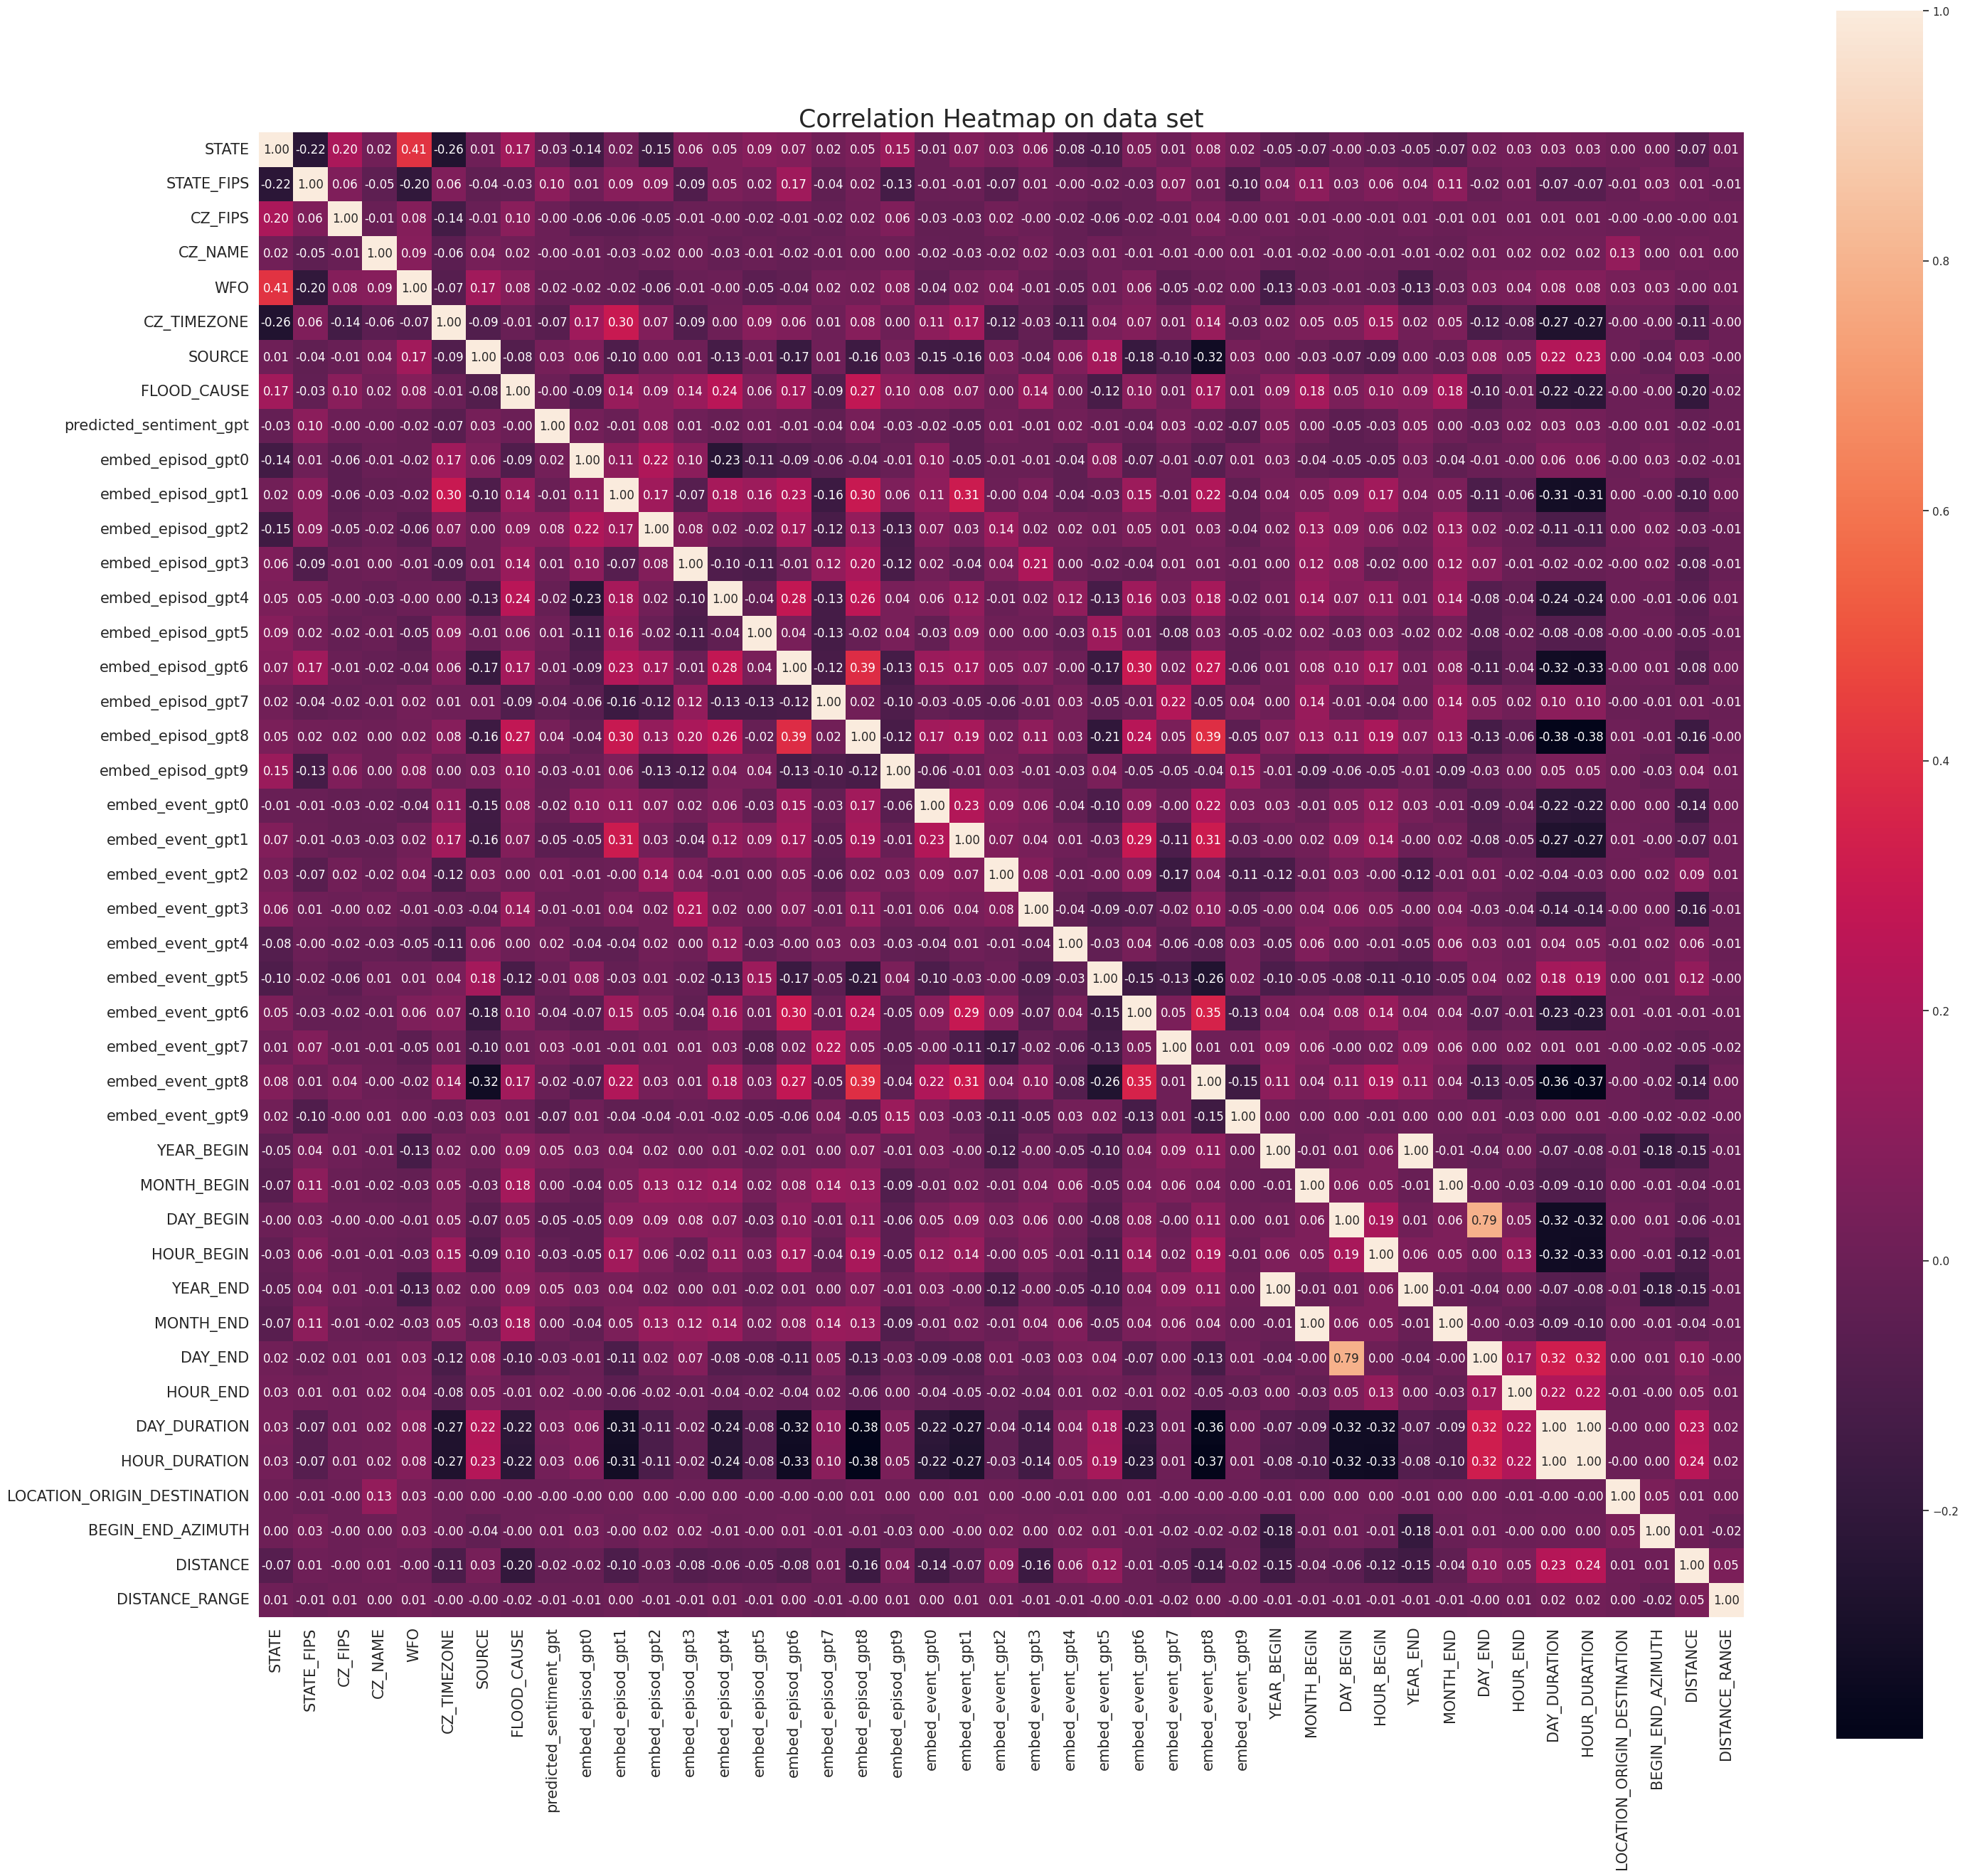

In [31]:
# Correlation heatmap
corr_matrix = X_all_v.corr()
sns.set( rc = {'figure.figsize': (30, 30)})
plt.figure()
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=25)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [32]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['YEAR_END', 'MONTH_END', 'DAY_END', 'HOUR_DURATION']

In [33]:
# Drop features
X_all_f = X_all_v.drop(X_all_v[to_drop], axis=1)

In [34]:
# Look at the new data set
X_all_f.shape

(38398, 39)

### Standardization

In [35]:
scaling=MinMaxScaler()

In [36]:
num1_ = ['STATE_FIPS',
'CZ_FIPS',
'YEAR_BEGIN',
'MONTH_BEGIN',
'DAY_BEGIN',
'HOUR_BEGIN',
'HOUR_END',
'DAY_DURATION',
'DISTANCE',
'DISTANCE_RANGE']

In [37]:
num2_=['embed_episod_gpt0',
'embed_episod_gpt1',
'embed_episod_gpt2',
'embed_episod_gpt3',
'embed_episod_gpt4',
'embed_episod_gpt5',
'embed_episod_gpt6',
'embed_episod_gpt7',
'embed_episod_gpt8',
'embed_episod_gpt9',
'embed_event_gpt0',
'embed_event_gpt1',
'embed_event_gpt2',
'embed_event_gpt3',
'embed_event_gpt4',
'embed_event_gpt5',
'embed_event_gpt6',
'embed_event_gpt7',
'embed_event_gpt8',
'embed_event_gpt9']

In [38]:
cat_=['STATE',
'CZ_NAME',
'WFO',
'CZ_TIMEZONE',
'SOURCE',
'FLOOD_CAUSE',
'BEGIN_END_AZIMUTH',
'LOCATION_ORIGIN_DESTINATION',
'predicted_sentiment_gpt']

In [39]:
cat_new=X_all_f[cat_]
num1_new=X_all_f[num1_]
num2_new=X_all_f[num2_]

In [40]:
# Features to scale
num_sc=pd.DataFrame(scaling.fit_transform(num1_new), columns = ['STATE_FIPS',
'CZ_FIPS',
'YEAR_BEGIN',
'MONTH_BEGIN',
'DAY_BEGIN',
'HOUR_BEGIN',
'HOUR_END',
'DAY_DURATION',
'DISTANCE',
'DISTANCE_RANGE'], index=cat_new.index)

In [41]:
# New data set
X_all_sc = pd.concat([cat_new, num_sc, num2_new],axis='columns')

### Split data set

In [42]:
# Attach Target variable
all = pd.concat([df_2[['DEATHS_DIRECT']], X_all_sc], axis=1)
# Split data set train/test set : test set is built on the last year
train = all[all.index < '2022-01-01']
test = all[all.index >= '2022-01-01']
len(train), len(test)

(36497, 1901)

### Modelling & Evaluation

### Naive

### Prediction

In [43]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.DEATHS_DIRECT)
y_train = pd.DataFrame(X_train, columns=['DEATHS_DIRECT'])
X_train.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_test = test.copy()
y_test = np.log1p(X_test.DEATHS_DIRECT)
y_test = pd.DataFrame(X_test, columns=['DEATHS_DIRECT'])
X_test.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
y_train['naive_predictions'] = y_train['DEATHS_DIRECT'].shift(1)
y_test['naive_predictions'] = y_test['DEATHS_DIRECT'].shift(1)
predictions_tr = y_train.drop(columns="DEATHS_DIRECT")
predictions_te = y_test.drop(columns="DEATHS_DIRECT")
#ID_predict = predictions_te
mse_train = mean_squared_error(y_train.iloc[1:,0], predictions_tr.iloc[1:,0])
mse_test = mean_squared_error(y_test.iloc[1:,0], predictions_te.iloc[1:,0])
mae_train = mean_absolute_error(y_train.iloc[1:,0], predictions_tr.iloc[1:,0])
mae_test = mean_absolute_error(y_test.iloc[1:,0], predictions_te.iloc[1:,0])
score = []
score_dict = {
        'mse_train': mse_train,
        'mse_test': mse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
    }

score.append(score_dict)
score_naive = pd.DataFrame(score, columns = ['mse_train', 'mse_test','mae_train','mae_test'])
predictions_te_naive = predictions_te.copy()
X_test = X_test.reset_index(drop=True)
#pred_naive = pd.concat([predictions_te_naive, X_test], axis=1)

### Evaluation

In [44]:
naive_results = {'model':['naive'],
               'mse_train':score_naive['mse_train'],
               'mse_test': score_naive['mse_test'],
              'mae_train': score_naive['mae_train'],
              'mae_test': score_naive['mae_test'],}
score_naive = pd.DataFrame(naive_results,
                         columns=['model', 'mse_train', 'mse_test','mae_train','mae_test'])
score_naive

,model,mse_train,mse_test,mae_train,mae_test
0,naive,0.034744,0.043158,0.020276,0.02


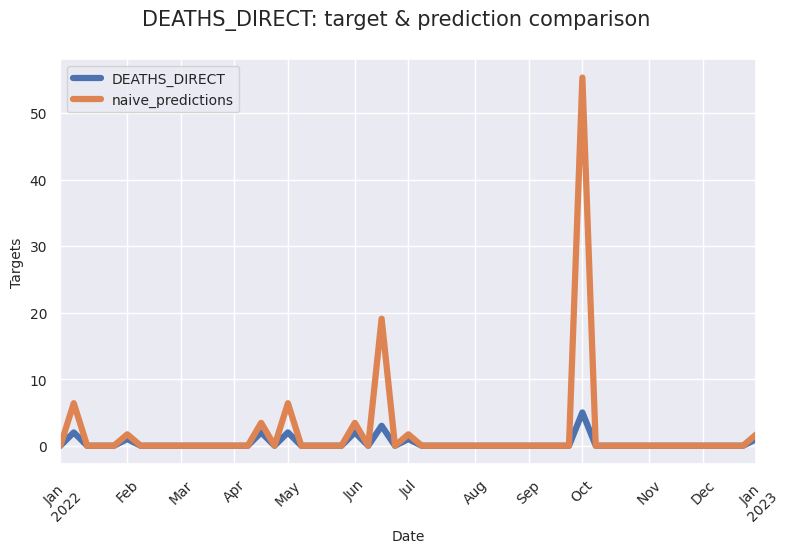

In [45]:
test_df = all[all.index >= '2022-01-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_naive.set_index(test_df.index))], axis=1)
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='W')).agg({
    'DEATHS_DIRECT': 'sum',
    'naive_predictions': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### GLM

### Prediction

In [46]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.DEATHS_DIRECT)
X_train.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_test = test.copy()
y_test = np.log1p(X_test.DEATHS_DIRECT)
X_test.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
glm = TweedieRegressor(power=1, link='log') # GLM with Poisson distribution
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
score = []
glm_model = GridSearchCV(glm,param_grid,cv=tscv)
glm_model.fit(X_train, y_train)
predictions_tr = glm_model.predict(X_train)
predictions_te = glm_model.predict(X_test)
#ID_predict = predictions_te
mse_train = mean_squared_error(y_train, predictions_tr)
mse_test = mean_squared_error(y_test, predictions_te)
mae_train = mean_absolute_error(y_train, predictions_tr)
mae_test = mean_absolute_error(y_test, predictions_te)

score_dict = {
        'mse_train': mse_train,
        'mse_test': mse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
    }

score.append(score_dict)
score_glm = pd.DataFrame(score, columns = ['mse_train', 'mse_test','mae_train','mae_test'])
predictions_te_glm = pd.DataFrame(predictions_te, columns = ['DEATHS_DIRECT_predict_glm'])
X_test = X_test.reset_index(drop=True)
pred_glm = pd.concat([predictions_te_glm, X_test], axis=1)

### Evaluation

In [47]:
glm_results = {'model':['glm'],
               'mse_train':score_glm['mse_train'],
               'mse_test': score_glm['mse_test'],
              'mae_train': score_glm['mae_train'],
              'mae_test': score_glm['mae_test'],}
score_glm = pd.DataFrame(glm_results,
                         columns=['model', 'mse_train', 'mse_test','mae_train','mae_test'])
score_glm

,model,mse_train,mse_test,mae_train,mae_test
0,glm,0.005527,0.005634,0.013102,0.012167


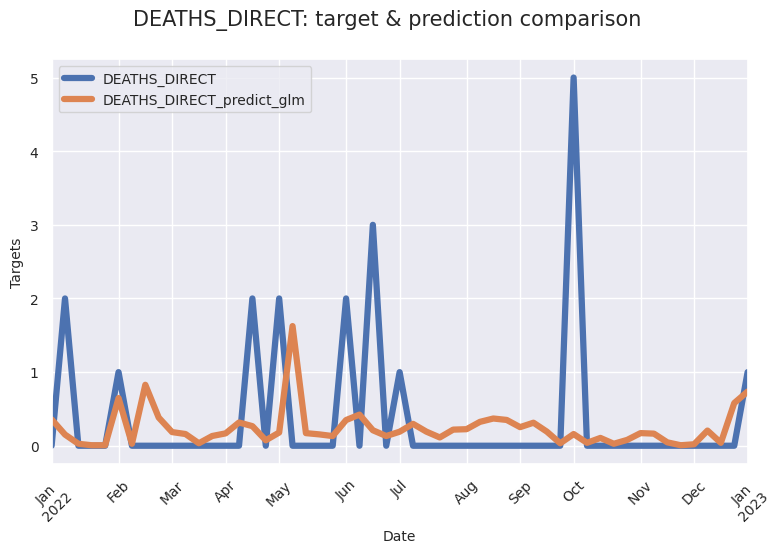

In [48]:
test_df = all[all.index >= '2022-01-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_glm.set_index(test_df.index))], axis=1)
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='W')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_predict_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

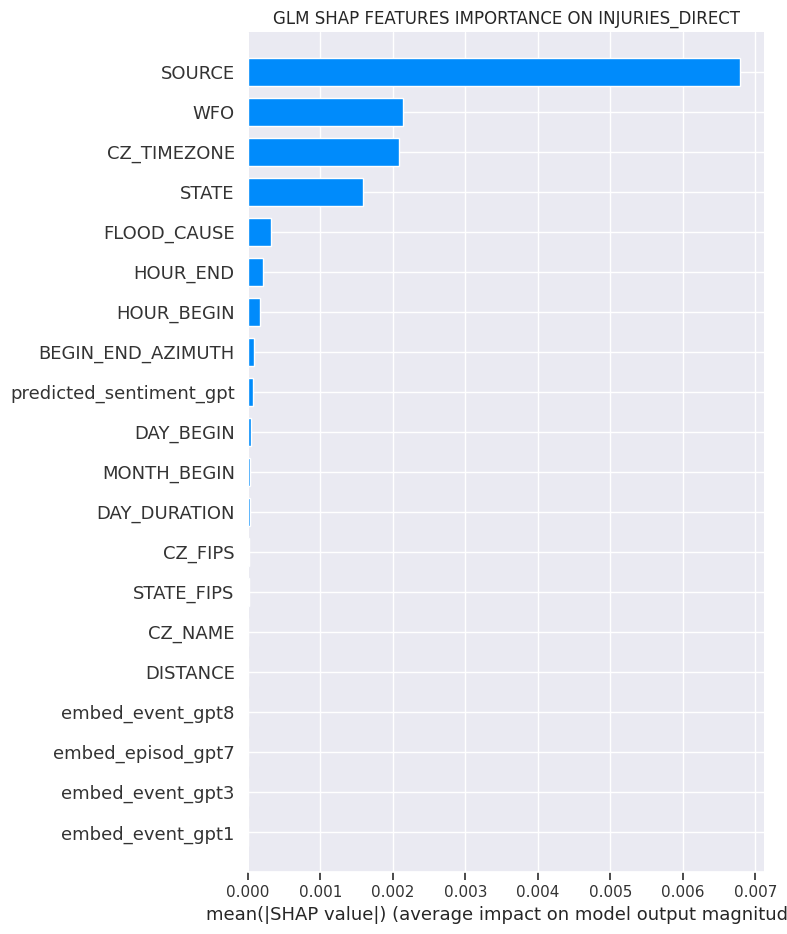

In [49]:
# Global SHAP on GLM
GLM_ = TweedieRegressor(power=1, link='log').fit(X_test, y_test)
masker = shap.maskers.Independent(X_test)
GLM_explainer = shap.LinearExplainer(GLM_, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON INJURIES_DIRECT")
shap.summary_plot(GLM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')

### LightGBM

### Prediction

In [50]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.DEATHS_DIRECT)
X_train.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_test = test.copy()
y_test = np.log1p(X_test.DEATHS_DIRECT)
X_test.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
lgbm =  LGBMRegressor(
        objective='poisson',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
score = []
lgbm_model = GridSearchCV(lgbm,param_grid,cv=tscv)
lgbm_model.fit(X_train, y_train)
predictions_tr = lgbm_model.predict(X_train)
predictions_te = lgbm_model.predict(X_test)
#ID_predict = predictions_te
mse_train = mean_squared_error(y_train, predictions_tr)
mse_test = mean_squared_error(y_test, predictions_te)
mae_train = mean_absolute_error(y_train, predictions_tr)
mae_test = mean_absolute_error(y_test, predictions_te)

score_dict = {
        'mse_train': mse_train,
        'mse_test': mse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
    }

score.append(score_dict)
score_lgbm = pd.DataFrame(score, columns = ['mse_train', 'mse_test','mae_train','mae_test'])
predictions_te_lgbm = pd.DataFrame(predictions_te, columns = ['DEATHS_DIRECT_predict_lgbm'])
X_test = X_test.reset_index(drop=True)
pred_lgbm = pd.concat([predictions_te_lgbm, X_test], axis=1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5774
[LightGBM] [Info] Number of data points in the train set: 6087, number of used features: 38
[LightGBM] [Info] Start training from score -4.949029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5818
[LightGBM] [Info] Number of data points in the train set: 12169, number of used features: 38
[LightGBM] [Info] Start training from score -4.873004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5864
[LightGBM] [Info] Number of data points in the train se

### Evaluation

In [51]:
lgbm_results = {'model':['lgbm'],
               'mse_train':score_lgbm['mse_train'],
               'mse_test': score_lgbm['mse_test'],
              'mae_train': score_lgbm['mae_train'],
              'mae_test': score_lgbm['mae_test'],}
score_lgbm = pd.DataFrame(lgbm_results,
                         columns=['model', 'mse_train', 'mse_test','mae_train','mae_test'])
score_lgbm

,model,mse_train,mse_test,mae_train,mae_test
0,lgbm,0.000866,0.005195,0.004518,0.007358


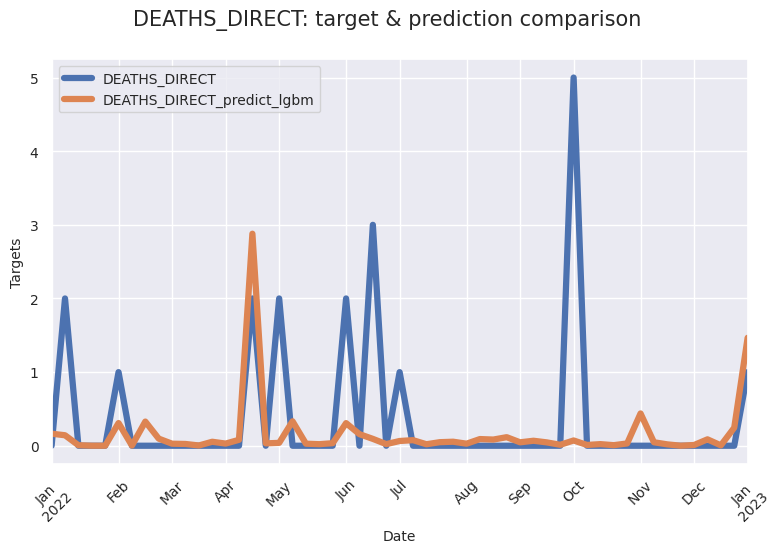

In [52]:
test_df = all[all.index >= '2022-01-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_lgbm.set_index(test_df.index))], axis=1)
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='W')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_predict_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5676
[LightGBM] [Info] Number of data points in the train set: 1901, number of used features: 37
[LightGBM] [Info] Start training from score -5.176334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

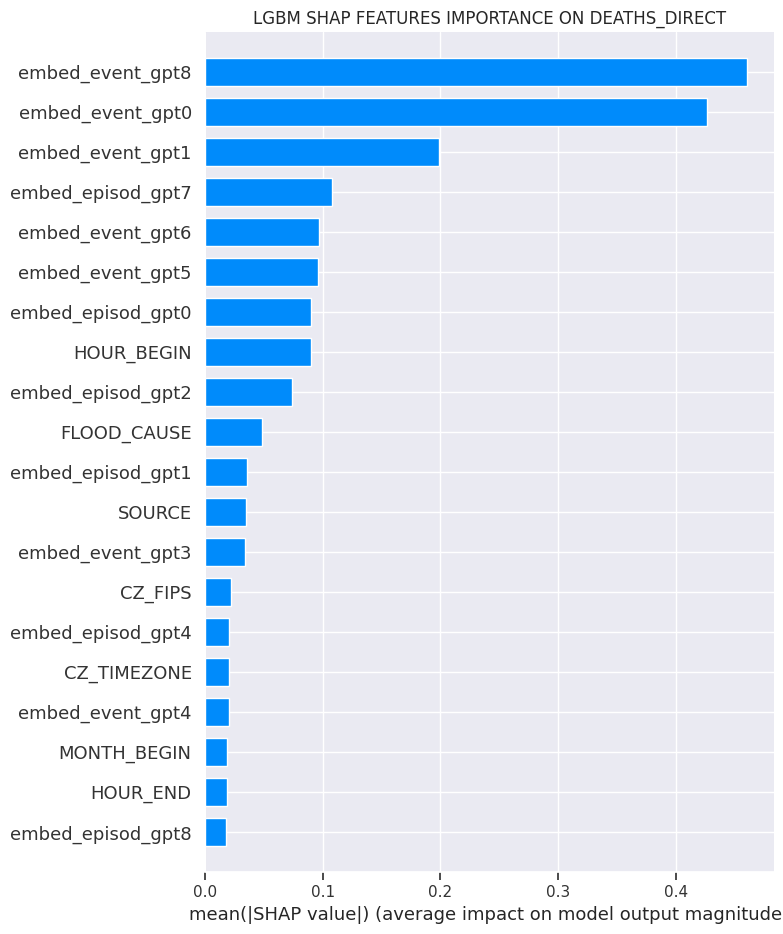

In [53]:
# Global SHAP on LGBM
LGBM_ = LGBMRegressor(
        objective='poisson',random_state=0).fit(X_test, y_test)
LGBM_explainer = shap.TreeExplainer(LGBM_)
LGBM_shap_values = LGBM_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("LGBM SHAP FEATURES IMPORTANCE ON DEATHS_DIRECT")
shap.summary_plot(LGBM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')

### NN

### Prediction

In [54]:
# fit the model
X_train = train.copy()
y_train = np.log1p(X_train.DEATHS_DIRECT)
X_train.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
X_test = test.copy()
y_test = np.log1p(X_test.DEATHS_DIRECT)
X_test.drop(['DEATHS_DIRECT'], axis=1, inplace=True)
nn =  MLPRegressor(random_state=0, hidden_layer_sizes=(10,), activation='relu', max_iter=1000, early_stopping=True)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
score = []
nn_model = GridSearchCV(nn,param_grid,cv=tscv)
nn_model.fit(X_train, y_train)
predictions_tr = nn_model.predict(X_train)
predictions_te = nn_model.predict(X_test)
mse_train = mean_squared_error(y_train, predictions_tr)
mse_test = mean_squared_error(y_test, predictions_te)
mae_train = mean_absolute_error(y_train, predictions_tr)
mae_test = mean_absolute_error(y_test, predictions_te)

score_dict = {
        'mse_train': mse_train,
        'mse_test': mse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
    }

score.append(score_dict)
score_nn = pd.DataFrame(score, columns = ['mse_train', 'mse_test','mae_train','mae_test'])
predictions_te_nn = pd.DataFrame(predictions_te, columns = ['DEATHS_DIRECT_predict_nn'])
X_test = X_test.reset_index(drop=True)
pred_nn = pd.concat([predictions_te_nn, X_test], axis=1)

### Evalaution

In [55]:
nn_results = {'model':['nn'],
               'mse_train':score_nn['mse_train'],
               'mse_test': score_nn['mse_test'],
              'mae_train': score_nn['mae_train'],
              'mae_test': score_nn['mae_test'],}
score_nn = pd.DataFrame(nn_results,
                         columns=['model', 'mse_train', 'mse_test','mae_train','mae_test'])
score_nn

,model,mse_train,mse_test,mae_train,mae_test
0,nn,0.005409,0.005499,0.018938,0.018001


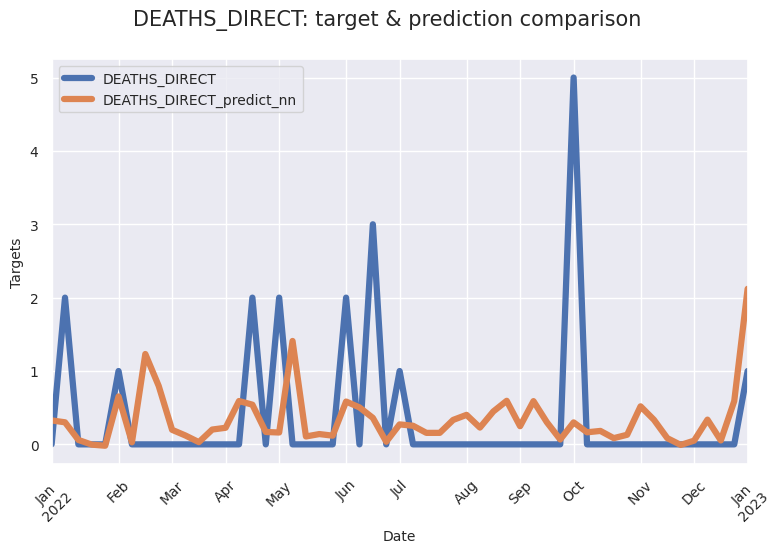

In [56]:
test_df = all[all.index >= '2022-01-01']
test_df = pd.concat([test_df, np.expm1(predictions_te_nn.set_index(test_df.index))], axis=1)
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='W')).agg({
    'DEATHS_DIRECT': 'sum',
    'DEATHS_DIRECT_predict_nn': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('DEATHS_DIRECT: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

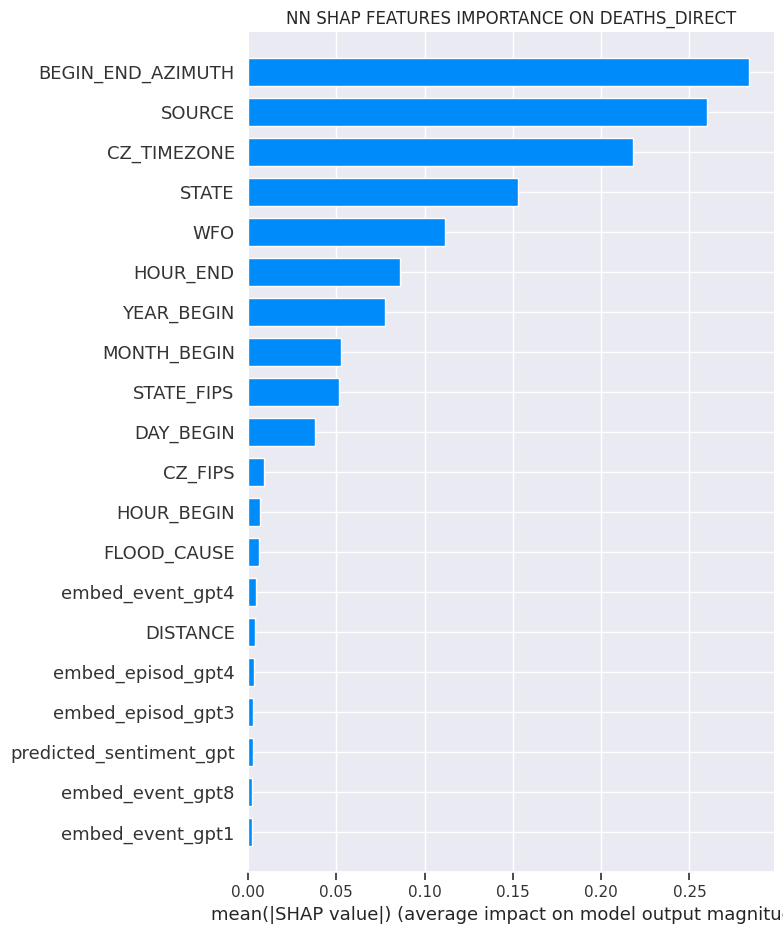

In [57]:
# Global SHAP on NN
NN_ = MLPRegressor(random_state=0, hidden_layer_sizes=(10,), activation='relu', max_iter=1000, early_stopping=True).fit(X_test, y_test)
NN_explainer = shap.KernelExplainer(NN_.predict, X_train.iloc[0:100])
NN_shap_values = NN_explainer.shap_values(X_test.iloc[0:100])
plt.rcParams['figure.figsize'] = (5,5)
plt.title("NN SHAP FEATURES IMPORTANCE ON DEATHS_DIRECT")
shap.summary_plot(NN_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')